## Arm Reaching (RM Session 1)

In [1]:
import os
import glob
import numpy as np
import mne
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from google.colab import drive
# drive.mount('/content/drive')
from scipy.io import loadmat
from scipy.signal import butter, lfilter
warnings.filterwarnings('ignore')

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
folder = r'converted data'
files = os.listdir(folder)
files

['Session_1_RM_Sub_10_arm_reaching_classes.fif',
 'Session_1_RM_Sub_10_rest_class.fif',
 'Session_1_RM_Sub_1_arm_reaching_classes.fif',
 'Session_1_RM_Sub_1_rest_class.fif',
 'Session_1_RM_Sub_2_arm_reaching_classes.fif',
 'Session_1_RM_Sub_2_rest_class.fif',
 'Session_1_RM_Sub_3_arm_reaching_classes.fif',
 'Session_1_RM_Sub_3_rest_class.fif',
 'Session_1_RM_Sub_4_arm_reaching_classes.fif',
 'Session_1_RM_Sub_4_rest_class.fif',
 'Session_1_RM_Sub_5_arm_reaching_classes.fif',
 'Session_1_RM_Sub_5_rest_class.fif',
 'Session_1_RM_Sub_6_arm_reaching_classes.fif',
 'Session_1_RM_Sub_6_rest_class.fif',
 'Session_1_RM_Sub_7_arm_reaching_classes.fif',
 'Session_1_RM_Sub_7_rest_class.fif',
 'Session_1_RM_Sub_8_arm_reaching_classes.fif',
 'Session_1_RM_Sub_8_rest_class.fif',
 'Session_1_RM_Sub_9_arm_reaching_classes.fif',
 'Session_1_RM_Sub_9_rest_class.fif']

In [5]:
decode = {11: 0, 21: 1, 31: 2, 41:3, 51: 4, 61: 5, 8 :6}
labels = []

data = []
for file in files:
    if file.__contains__('rest_class'):
        continue

    epochs = mne.read_epochs(os.path.join(folder,file))
    epochs.pick_types(eeg=True)

    # apply down sampling if needed
    epochs.resample(sfreq=625)

    tmp_data = epochs.get_data()

    if data==[]:
        data = tmp_data
    else:
        data = np.concatenate((data, tmp_data), axis=0)

    for i in epochs.events:
        labels.append(decode[i[2]])


Reading d:\EEG_RawData\Arm-Reaching-RM\Multiple subjects\converted data\Session_1_RM_Sub_10_arm_reaching_classes.fif ...
    Found the data of interest:
        t =    3000.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Reading d:\EEG_RawData\Arm-Reaching-RM\Multiple subjects\converted data\Session_1_RM_Sub_1_arm_reaching_classes.fif ...
    Found the data of interest:
        t =    3000.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Reading d:\EEG_RawData\Arm-Reaching-RM\Multiple subjects\converted data\Session_1_RM_Sub_2_arm_reaching_classes.fif ...
    Found the data of interest:
        t =    3000.00 ...    7000.00 ms
        0 CTF compensation matrices available
Not setting metadata
300 matching events found
No baseline correctio

In [6]:
data.shape

(3000, 32, 2500)

In [7]:
labels = np.array(labels)
labels.shape

(3000,)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2,stratify=labels,shuffle=True)

In [7]:
# ind = np.argsort(y_train)
# y_train = y_train[ind]
# X_train = X_train[ind]

In [8]:
# ind = np.argsort(y_val)
# y_val = y_val[ind]
# X_val = X_val[ind]

In [9]:
y_train=tf.keras.utils.to_categorical(y_train,num_classes=6) 
y_val=tf.keras.utils.to_categorical(y_val,num_classes=6) 

In [10]:
print('X_train: ',X_train.shape)
print('X_val:   ',X_val.shape)
print('y_train: ',y_train.shape)
print('y_val:   ',y_val.shape)

X_train:  (2400, 32, 2500)
X_val:    (600, 32, 2500)
y_train:  (2400, 6)
y_val:    (600, 6)


In [11]:
# Normaliation
# X_train = MinMaxScaler().fit_transform(X_train)
# X_val = MinMaxScaler().fit_transform(X_val)
X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_val = (X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val))

## Model CNN

In [12]:
from EEGModels import EEGNet 
model = EEGNet(nb_classes=6, Chans = 32, Samples = 2500, dropoutRate = 0.2, kernLength = 64, F1 = 8, D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout')

In [13]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 2500, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 32, 2500, 8)       512       
                                                                 
 batch_normalization (BatchN  (None, 32, 2500, 8)      32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 2500, 16)      512       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 2500, 16)      64        
 hNormalization)                                                 
                                                             

In [20]:
Epochs=10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = model.fit(X_train,y_train,
                    epochs=Epochs,
                    validation_data=(X_val,y_val),
                    batch_size=32,
                    verbose=1)    #,callbacks=[early_stopping]

Epoch 1/10
75/75 [==============================] - 72s 963ms/step - loss: 0.1237 - accuracy: 0.2225 - val_loss: 0.1273 - val_accuracy: 0.1650
Epoch 2/10
75/75 [==============================] - 74s 990ms/step - loss: 0.1235 - accuracy: 0.2346 - val_loss: 0.1285 - val_accuracy: 0.1550
Epoch 3/10
75/75 [==============================] - 73s 977ms/step - loss: 0.1234 - accuracy: 0.2442 - val_loss: 0.1263 - val_accuracy: 0.1700
Epoch 4/10
75/75 [==============================] - 72s 954ms/step - loss: 0.1232 - accuracy: 0.2525 - val_loss: 0.1273 - val_accuracy: 0.1600
Epoch 5/10
75/75 [==============================] - 73s 979ms/step - loss: 0.1230 - accuracy: 0.2592 - val_loss: 0.1263 - val_accuracy: 0.1517
Epoch 6/10
75/75 [==============================] - 73s 977ms/step - loss: 0.1229 - accuracy: 0.2650 - val_loss: 0.1270 - val_accuracy: 0.1550
Epoch 7/10
75/75 [==============================] - 73s 977ms/step - loss: 0.1227 - accuracy: 0.2683 - val_loss: 0.1281 - val_accuracy: 0.1633

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

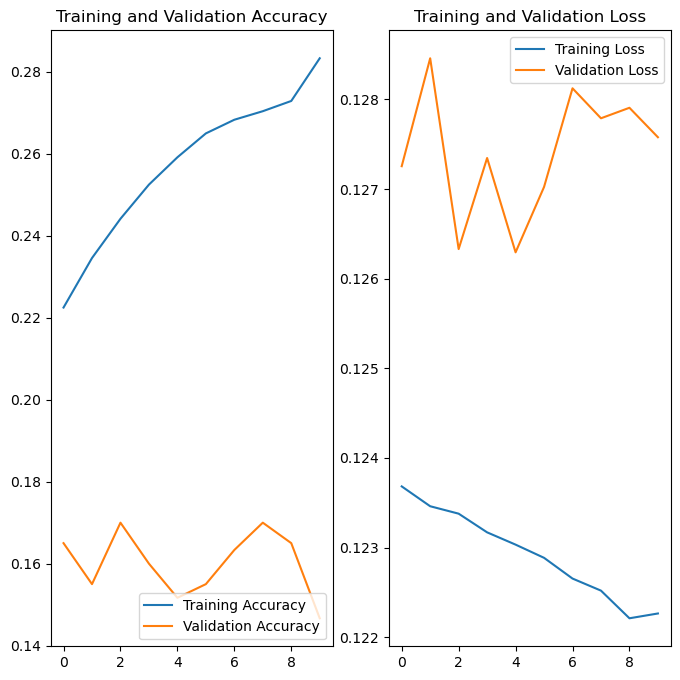

In [22]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
model.evaluate(X_train,y_train)

75/75 [==============================] - 8s 106ms/step - loss: 0.1213 - accuracy: 0.2754


[0.12126870453357697, 0.27541667222976685]

In [24]:
model.evaluate(X_val,y_val)

19/19 [==============================] - 2s 106ms/step - loss: 0.1276 - accuracy: 0.1467


[0.12757791578769684, 0.14666666090488434]